# 평가

분류의 성능 평가 지표

- 정확도

- 오차행렬

- 정밀도

- 재현율

- F1 스코어

- ROC AUC

## ref. W02

In [1]:
from sklearn import preprocessing

In [2]:
# 결측값 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket',], axis=1, inplace=True)
    return df

# 레이블인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

## 01. 정확도(Accuracy)

$\text{정확도} = \dfrac{\text{예측 결과가 동일한 데이터 건수}}{\text{전체 예측 데이터 건수}}$

### Titanic

In [3]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

In [4]:
class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None): # fit() 메서드는 아무것도 학습하지 않는다.
        pass
    
    def predict(self, X): # predict() 메서드는 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측하는 단순한 Classifier
        pred = np.zeros( (X.shape[0], 1)) # X.shape[0]는 X의 행 개수
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
# 데이터를 로딩
titanic_df = pd.read_csv('data/titanic_train.csv')

In [7]:
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [8]:
# 학습 데이터/테스트 데이터 분할
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

In [9]:
# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()

In [10]:
myclf.fit(X_train, y_train)

In [11]:
mypredictions = myclf.predict(X_test)

In [12]:
mypredictions[:5] # ndarray는 head, tail을 지원하지 않으므로 이와 같이 사용한다.

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [13]:
print('Dummy Classifier의 정확도는: {0}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877094972067039


### MNIST

In [14]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

In [15]:
class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1), dtype=bool)

In [16]:
digits = load_digits()

In [17]:
y = (digits.target == 7).astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [19]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64


In [20]:
# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 : ', accuracy_score(y_test, fakepred))

모든 예측을 0으로 하여도 정확도는 :  0.9


이런 말도 안되는 예측을 성능 수치로 사용해서는 안된다.

정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다.

## 02. 오차행렬

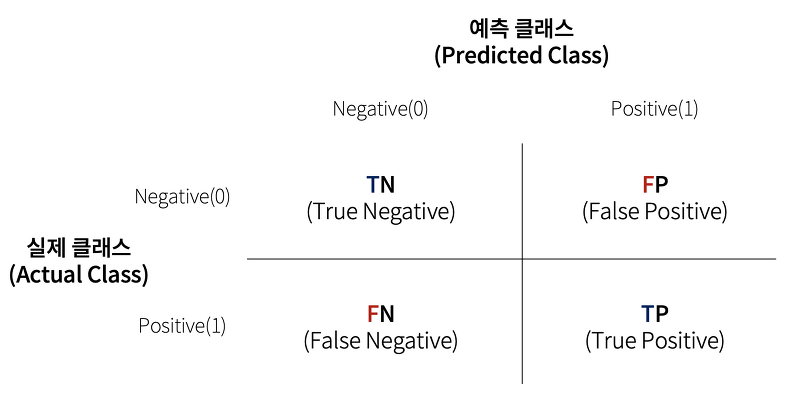

FN : 위음성

FP : 위양성

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

$정확도 = \dfrac{\text{예측 결과와 실제 값이 동일한 건수}}{\text{전체 데이터 수}} = \dfrac{TN+TP}{TN+FP+FN+TP}$

## 03. 정밀도와 재현율

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표입니다.

- 정밀도 : 예측을 Positive로 한 대상 중에 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다.

- 재현율 : 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다.

$정밀도 = \dfrac{TP}{FP+TP}$ = `precision_score()`

$재현율 = \dfrac{TP}{FN+TP}$ = `recall_score()`

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [24]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0}, 정밀도 : {1}, 재현성 : {2}'.format(accuracy, precision, recall))

In [25]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측하고 confusion matrix, accuracy, precision, recall 평가를 수행합니다.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('data/titanic_train.csv')

In [26]:
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size = 0.2, random_state = 11)

In [28]:
lr_clf = LogisticRegression()

In [29]:
lr_clf.fit(X_train, y_train)

C:\Users\woo\anaconda3\envs\py39r41\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
pred = lr_clf.predict(X_test)

In [31]:
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8491620111731844, 정밀도 : 0.7741935483870968, 재현성 : 0.7868852459016393


### 정밀도/재현율 트레이드오프

## 05. ROC 곡선과 AUC

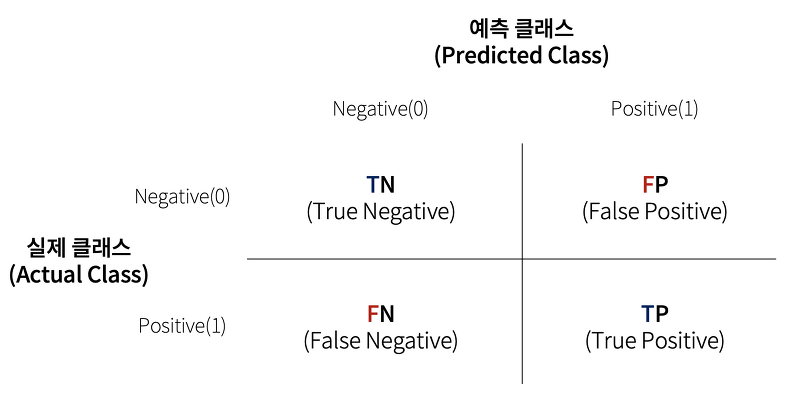

ROC 곡선은 FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선이다.

- TPR : True Positive Rate = $\dfrac{TP}{FN+TP}$ = 실제로도 양성인 것들 중에서, 양성이라고 판단한 비율 = 재현율 = 민감도

- FPR : False Positive Rate = $\dfrac{FP}{FP+TN}$ = 실제로는 음성인 것들 중에서, 양성이라고 잘못 판단한 비율

---

- TNR : True Negative Rate = $\dfrac{TN}{FP+TN}$ = 실제로도 음성인 것을, 음성이라고 판단한 비율 = 특이도

- $TNR = 1 - FPR$

In [32]:
a = '123'

In [33]:
print('asdf {0},\
    dsdf'.format(a))

asdf 123,    dsdf


In [36]:
print('asdf {0}\
dsdf'.format(a))

asdf 123dsdf


In [37]:
 from sklearn.neighbors import KNeighborsClassifier

In [40]:
import matplotlib.pyplot as plt

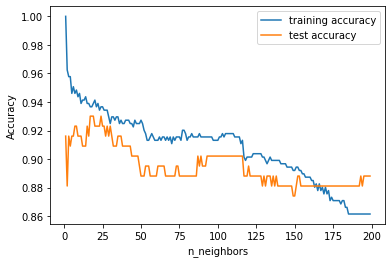

In [41]:
from sklearn.datasets import load_breast_cancer

cancer= load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
cancer.data, cancer.target, stratify=cancer.target, random_state=0)

training_accuracy = []
test_accuracy = []

neighbors_settings = range(1,200)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    training_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
